In [ ]:
import torch
import gc
import os
import requests
import numpy as np
from PIL import Image, ImageDraw, ImageFont, ImageFilter, ImageOps, ImageChops
from torchvision import transforms
from transformers import AutoModelForImageSegmentation, BitsAndBytesConfig
from diffusers import (
    FluxPipeline,
    FluxImg2ImgPipeline, # Img2Img 파이프라인 추가
    FluxTransformer2DModel,
    StableDiffusionXLControlNetPipeline, 
    ControlNetModel, 
    AutoencoderKL
)
from diffusers.utils import load_image
import matplotlib.pyplot as plt

# ==========================================
# ⚙️ 설정
# ==========================================
DEVICE = "cuda"
TORCH_DTYPE = torch.bfloat16 

MODEL_IDS = {
    "SEG": "ZhengPeng7/BiRefNet",
    "FLUX": "black-forest-labs/FLUX.1-dev",
    "SDXL_BASE": "stabilityai/stable-diffusion-xl-base-1.0",
    "SDXL_CNET": "diffusers/controlnet-canny-sdxl-1.0",
    "SDXL_VAE": "madebyollin/sdxl-vae-fp16-fix"
}

def flush():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

def download_font(font_name="NanumGothicBold.ttf"):
    if not os.path.exists(font_name):
        url = "https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Bold.ttf"
        r = requests.get(url)
        with open(font_name, 'wb') as f:
            f.write(r.content)
    return font_name

def pil_canny_edge(image):
    gray = image.convert("L")
    edges = gray.filter(ImageFilter.FIND_EDGES)
    edges = edges.point(lambda x: 255 if x > 30 else 0)
    return edges.convert("RGB")

def visualize_report(images_dict, title="Pipeline Report"):
    n = len(images_dict)
    cols = 4 # 4열로 보기
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(24, 6 * rows))
    plt.suptitle(title, fontsize=24, fontweight='bold', y=0.98)
    for i, (key, img) in enumerate(images_dict.items()):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(key, fontsize=12, fontweight='bold')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# --- AI 실행 함수들 ---
def _run_birefnet_seg(image):
    print("    [AI] BiRefNet 실행...")
    flush()
    birefnet = AutoModelForImageSegmentation.from_pretrained(
        MODEL_IDS["SEG"], trust_remote_code=True
    ).to(DEVICE).eval()
    
    W, H = image.size
    img_resized = image.resize((1024, 1024), Image.LANCZOS)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    input_tensor = transform(img_resized).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        preds = birefnet(input_tensor)[-1].sigmoid().cpu()
    pred = preds[0].squeeze()
    mask = transforms.ToPILImage()(pred).resize((W, H), Image.LANCZOS)
    mask = mask.point(lambda x: 255 if x > 128 else 0)
    
    result = image.copy()
    result.putalpha(mask)
    del birefnet, input_tensor
    flush()
    return result, mask

def _run_flux_bg_gen():
    print("    [AI] Flux (Txt2Img) 실행...")
    flush()
    quant_config = BitsAndBytesConfig(load_in_8bit=True)
    transformer = FluxTransformer2DModel.from_pretrained(
        MODEL_IDS["FLUX"], subfolder="transformer", quantization_config=quant_config, torch_dtype=TORCH_DTYPE
    )
    pipe = FluxPipeline.from_pretrained(
        MODEL_IDS["FLUX"], transformer=transformer, torch_dtype=TORCH_DTYPE
    )
    pipe.enable_model_cpu_offload()
    
    prompt = (
        "A close-up view of a rustic wooden table surface. "
        "Soft morning sunlight coming from a window, creating gentle shadows. "
        "Blurred cozy kitchen background, bokeh, photorealistic, 8k, cinematic lighting."
    )
    image = pipe(
        prompt, height=1024, width=1024, num_inference_steps=25, guidance_scale=3.5,
        generator=torch.Generator("cpu").manual_seed(42)
    ).images[0]
    del pipe, transformer
    flush()
    return image

def _run_flux_refinement(draft_image):
    """
    [A-7 단계] Img2Img로 부자연스러운 합성(Draft)을 자연스럽게 만듭니다.
    """
    print("    [AI] Flux (Img2Img) 리터칭 실행...")
    flush()
    quant_config = BitsAndBytesConfig(load_in_8bit=True)
    transformer = FluxTransformer2DModel.from_pretrained(
        MODEL_IDS["FLUX"], subfolder="transformer", quantization_config=quant_config, torch_dtype=TORCH_DTYPE
    )
    # 중요: Img2Img 파이프라인 사용
    pipe = FluxImg2ImgPipeline.from_pretrained(
        MODEL_IDS["FLUX"], transformer=transformer, torch_dtype=TORCH_DTYPE
    )
    pipe.enable_model_cpu_offload()
    
    prompt = (
        "A ripe yellow banana lying on a rustic wooden table. "
        "Natural shadows, sunlight, photorealistic, 8k, cinematic lighting, "
        "coherent blending, high quality."
    )
    
    # strength가 낮을수록 원본(draft) 유지, 높을수록 창의적 변형
    # 0.3 ~ 0.35 정도가 형태를 유지하면서 그림자만 계산하기에 적당함
    refined_image = pipe(
        prompt, 
        image=draft_image,
        strength=0.35, 
        num_inference_steps=25, 
        guidance_scale=3.5,
        generator=torch.Generator("cpu").manual_seed(42)
    ).images[0]
    
    del pipe, transformer
    flush()
    return refined_image

def _run_sdxl_text_gen(canny_map, prompt):
    print("    [AI] SDXL 실행...")
    flush()
    controlnet = ControlNetModel.from_pretrained(
        MODEL_IDS["SDXL_CNET"], torch_dtype=TORCH_DTYPE, use_safetensors=True
    )
    vae = AutoencoderKL.from_pretrained(MODEL_IDS["SDXL_VAE"], torch_dtype=TORCH_DTYPE)
    pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
        MODEL_IDS["SDXL_BASE"], controlnet=controlnet, vae=vae, torch_dtype=TORCH_DTYPE
    ).to(DEVICE)
    
    neg_prompt = "floor, ground, dirt, debris, random shapes, multiple objects, clutter, ugly, low quality"
    generated_img = pipe(
        prompt, negative_prompt=neg_prompt, image=canny_map, 
        controlnet_conditioning_scale=1.0, num_inference_steps=30
    ).images[0]
    del pipe, controlnet, vae
    flush()
    return generated_img

# ==========================================
# 🎨 STAGE A: 베이스 이미지 (+Refinement)
# ==========================================
def run_stage_a_detail(image_path):
    print("\n🔶 [STAGE A] 베이스 이미지 생성 (Refinement 추가)...")
    report = {}
    
    # 1. 원본 & 마스크
    raw_img = load_image(image_path).convert("RGB")
    report["A-1. Original Input"] = raw_img
    
    product_fg, product_mask = _run_birefnet_seg(raw_img)
    report["A-2. Product Mask"] = product_mask
    
    # 2. 배경 생성
    bg_img = _run_flux_bg_gen()
    report["A-4. Generated Background"] = bg_img
    
    # 3. 제품 배치 (Draft 합성)
    bg_w, bg_h = bg_img.size
    scale = 0.4
    fg_resized = product_fg.resize((int(product_fg.width*scale), int(product_fg.height*scale)), Image.LANCZOS)
    fg_mask = fg_resized.split()[-1]
    
    x = (bg_w - fg_resized.width) // 2
    y = int(bg_h * 0.55)
    
    shadow_layer = Image.new("RGBA", bg_img.size, (0,0,0,0))
    shadow_layer.paste((0,0,0,140), (x+20, y+40), mask=fg_mask)
    shadow_layer = shadow_layer.filter(ImageFilter.GaussianBlur(30))
    
    base_comp = bg_img.convert("RGBA")
    base_comp = Image.alpha_composite(base_comp, shadow_layer)
    fg_layer = Image.new("RGBA", bg_img.size)
    fg_layer.paste(fg_resized, (x, y))
    base_comp = Image.alpha_composite(base_comp, fg_layer)
    
    draft_final = base_comp.convert("RGB")
    report["A-6. Draft Composite (No Refine)"] = draft_final
    
    # 4. [NEW] A-7 Refinement (Harmonization)
    # 합성된 이미지를 Flux에 넣어 빛과 그림자를 다시 계산
    refined_final = _run_flux_refinement(draft_final)
    report["A-7. Refined Base Image (Flux)"] = refined_final
    
    return refined_final, report

# ==========================================
# 🅱️ STAGE B: 텍스트 자산
# ==========================================
def run_stage_b_detail(text="맛있는 바나나"):
    print("\n🔶 [STAGE B] 텍스트 자산 생성...")
    report = {}
    W, H = 1024, 1024
    
    # 1. 가이드
    font = ImageFont.truetype(download_font(), 160)
    text_guide = Image.new("RGB", (W, H), "black")
    draw = ImageDraw.Draw(text_guide)
    
    bbox = draw.textbbox((0,0), text, font=font)
    tw, th = bbox[2] - bbox[0], bbox[3] - bbox[1]
    text_x, text_y = (W - tw) // 2, 100
    
    draw.text((text_x, text_y), text, font=font, fill="white")
    canny_map = pil_canny_edge(text_guide)
    report["B-1. Text Guide"] = text_guide
    
    # 2. SDXL 생성
    prompt = (
        "3D render of Gold foil balloon text, inflated, shiny metallic texture, "
        "floating in air, cinematic lighting, sharp details, isolated on black background"
    )
    raw_3d_text = _run_sdxl_text_gen(canny_map, prompt)
    report["B-3. Raw SDXL Output"] = raw_3d_text
    
    # 3. 배경 제거
    transparent_text, _ = _run_birefnet_seg(raw_3d_text)
    
    # 4. Cleanup Mask (여유 공간 대폭 확대)
    cleanup_mask = Image.new("L", (W, H), 0)
    mask_draw = ImageDraw.Draw(cleanup_mask)
    
    # [Fix] 마스크 여유분(margin)을 50 -> 100으로 늘림
    # 글자가 잘리지 않도록 더 넉넉하게 잡음
    margin = 100 
    safe_area = (0, 0, W, text_y + th + margin)
    mask_draw.rectangle(safe_area, fill=255)
    
    report["B-4. Cleanup Mask (Zone)"] = cleanup_mask
    
    # 5. 마스크 적용
    r, g, b, a = transparent_text.split()
    clean_a = ImageChops.darker(a, cleanup_mask)
    final_text_asset = Image.merge("RGBA", (r, g, b, clean_a))
    
    report["B-5. Final Text Asset"] = final_text_asset
    
    return final_text_asset, report

# ==========================================
# 🖼️ STAGE C: 최종 합성
# ==========================================
def run_stage_c_detail(base_image, text_asset):
    print("\n🔶 [STAGE C] 최종 합성...")
    # Flux로 리터칭된 배경(base_image) 위에 텍스트를 올림
    final_comp = base_image.convert("RGBA")
    final_comp = Image.alpha_composite(final_comp, text_asset)
    final_result = final_comp.convert("RGB")
    return {"C-1. Final Composite": final_result}, final_result

# ==========================================
# 🚀 메인 실행
# ==========================================
def main_final_pipeline(image_path):
    print(f"🔥 [Start] Final Advanced Pipeline (Refinement Added)")
    full_report = {}
    
    # A (Refinement 포함)
    base_img, report_a = run_stage_a_detail(image_path)
    full_report.update(report_a)
    
    # B
    text_asset, report_b = run_stage_b_detail("맛있는 바나나")
    full_report.update(report_b)
    
    # C
    report_c, final_result = run_stage_c_detail(base_img, text_asset)
    full_report.update(report_c)
    
    # 시각화
    visualize_report(full_report)
    final_result.save("final_advanced_result.png")
    print("\n✨ 최종 고품질 광고 이미지 생성 완료")

main_final_pipeline("image.png")

In [ ]:
import torch
import gc
import os
import requests
import numpy as np
from PIL import Image, ImageDraw, ImageFont, ImageFilter, ImageOps, ImageChops
from torchvision import transforms
from transformers import AutoModelForImageSegmentation, BitsAndBytesConfig
from diffusers import (
    FluxPipeline,
    FluxImg2ImgPipeline, # 리터칭용 파이프라인 필수
    FluxTransformer2DModel,
    StableDiffusionXLControlNetPipeline, 
    ControlNetModel, 
    AutoencoderKL
)
from diffusers.utils import load_image
import matplotlib.pyplot as plt

# ==========================================
# ⚙️ 설정 (동일)
# ==========================================
DEVICE = "cuda"
TORCH_DTYPE = torch.bfloat16 

MODEL_IDS = {
    "SEG": "ZhengPeng7/BiRefNet",
    "FLUX": "black-forest-labs/FLUX.1-dev",
    "SDXL_BASE": "stabilityai/stable-diffusion-xl-base-1.0",
    "SDXL_CNET": "diffusers/controlnet-canny-sdxl-1.0",
    "SDXL_VAE": "madebyollin/sdxl-vae-fp16-fix"
}

def flush():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

def download_font(font_name="NanumGothicBold.ttf"):
    if not os.path.exists(font_name):
        url = "https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Bold.ttf"
        r = requests.get(url)
        with open(font_name, 'wb') as f:
            f.write(r.content)
    return font_name

def pil_canny_edge(image):
    gray = image.convert("L")
    edges = gray.filter(ImageFilter.FIND_EDGES)
    edges = edges.point(lambda x: 255 if x > 30 else 0)
    return edges.convert("RGB")

def visualize_report(images_dict, title="Pipeline Report"):
    n = len(images_dict)
    cols = 4
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(24, 6 * rows))
    plt.suptitle(title, fontsize=24, fontweight='bold', y=0.98)
    for i, (key, img) in enumerate(images_dict.items()):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(key, fontsize=12, fontweight='bold')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# --- AI 실행 함수들 ---
def _run_birefnet_seg(image):
    print("    [AI] BiRefNet 실행...")
    flush()
    birefnet = AutoModelForImageSegmentation.from_pretrained(
        MODEL_IDS["SEG"], trust_remote_code=True
    ).to(DEVICE).eval()
    
    W, H = image.size
    img_resized = image.resize((1024, 1024), Image.LANCZOS)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    input_tensor = transform(img_resized).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        preds = birefnet(input_tensor)[-1].sigmoid().cpu()
    pred = preds[0].squeeze()
    mask = transforms.ToPILImage()(pred).resize((W, H), Image.LANCZOS)
    mask = mask.point(lambda x: 255 if x > 128 else 0)
    
    result = image.copy()
    result.putalpha(mask)
    del birefnet, input_tensor
    flush()
    return result, mask

def _run_flux_bg_gen():
    print("    [AI] Flux (Txt2Img) 실행...")
    flush()
    quant_config = BitsAndBytesConfig(load_in_8bit=True)
    transformer = FluxTransformer2DModel.from_pretrained(
        MODEL_IDS["FLUX"], subfolder="transformer", quantization_config=quant_config, torch_dtype=TORCH_DTYPE
    )
    pipe = FluxPipeline.from_pretrained(
        MODEL_IDS["FLUX"], transformer=transformer, torch_dtype=TORCH_DTYPE
    )
    pipe.enable_model_cpu_offload()
    
    prompt = (
        "A close-up view of a rustic wooden table surface. "
        "Soft morning sunlight coming from a window, creating gentle shadows. "
        "Blurred cozy kitchen background, bokeh, photorealistic, 8k, cinematic lighting."
    )
    image = pipe(
        prompt, height=1024, width=1024, num_inference_steps=25, guidance_scale=3.5,
        generator=torch.Generator("cpu").manual_seed(42)
    ).images[0]
    del pipe, transformer
    flush()
    return image

def _run_flux_refinement(draft_image):
    """
    [중요] 과거 소스의 장점(사실적인 합성)을 가져오는 핵심 함수입니다.
    Img2Img로 어색한 합성(draft)을 자연스럽게 리터칭합니다.
    """
    print("    [AI] Flux (Img2Img) 리터칭 실행 (사실적 바나나)...")
    flush()
    quant_config = BitsAndBytesConfig(load_in_8bit=True)
    transformer = FluxTransformer2DModel.from_pretrained(
        MODEL_IDS["FLUX"], subfolder="transformer", quantization_config=quant_config, torch_dtype=TORCH_DTYPE
    )
    # Img2Img 파이프라인 사용
    pipe = FluxImg2ImgPipeline.from_pretrained(
        MODEL_IDS["FLUX"], transformer=transformer, torch_dtype=TORCH_DTYPE
    )
    pipe.enable_model_cpu_offload()
    
    # 과거 소스 스타일의 구체적인 프롬프트 적용
    prompt = (
        "A photorealistic close-up shot of a ripe yellow banana lying naturally on a rustic wooden table. "
        "Warm sunlight, realistic soft shadows, extremely detailed texture, depth of field, cinematic lighting."
    )
    
    # strength 0.35: 원본 형태는 유지하되 빛과 그림자를 자연스럽게 계산
    refined_image = pipe(
        prompt, 
        image=draft_image,
        strength=0.35, 
        num_inference_steps=30, 
        guidance_scale=3.5,
        generator=torch.Generator("cpu").manual_seed(42)
    ).images[0]
    
    del pipe, transformer
    flush()
    return refined_image

def _run_sdxl_text_gen(canny_map, prompt):
    print("    [AI] SDXL (3D 텍스트) 실행...")
    flush()
    controlnet = ControlNetModel.from_pretrained(
        MODEL_IDS["SDXL_CNET"], torch_dtype=TORCH_DTYPE, use_safetensors=True
    )
    vae = AutoencoderKL.from_pretrained(MODEL_IDS["SDXL_VAE"], torch_dtype=TORCH_DTYPE)
    pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
        MODEL_IDS["SDXL_BASE"], controlnet=controlnet, vae=vae, torch_dtype=TORCH_DTYPE
    ).to(DEVICE)
    
    neg_prompt = "floor, ground, dirt, debris, random shapes, multiple objects, clutter, ugly, low quality"
    generated_img = pipe(
        prompt, negative_prompt=neg_prompt, image=canny_map, 
        controlnet_conditioning_scale=1.0, num_inference_steps=30
    ).images[0]
    del pipe, controlnet, vae
    flush()
    return generated_img

# ==========================================
# 🎨 STAGE A: 베이스 이미지 (Refinement 활성화!)
# ==========================================
def run_stage_a_detail(image_path):
    print("\n🔶 [STAGE A] 베이스 이미지 생성 (사실적 리터칭)...")
    report = {}
    
    # 1. 원본 & 마스크
    raw_img = load_image(image_path).convert("RGB")
    product_fg, product_mask = _run_birefnet_seg(raw_img)
    report["A-2. Product Mask"] = product_mask
    
    # 2. 배경 생성
    bg_img = _run_flux_bg_gen()
    report["A-4. Generated Background"] = bg_img
    
    # 3. 제품 배치 (Draft 합성)
    bg_w, bg_h = bg_img.size
    scale = 0.4
    fg_resized = product_fg.resize((int(product_fg.width*scale), int(product_fg.height*scale)), Image.LANCZOS)
    fg_mask = fg_resized.split()[-1]
    
    x = (bg_w - fg_resized.width) // 2
    y = int(bg_h * 0.55)
    
    shadow_layer = Image.new("RGBA", bg_img.size, (0,0,0,0))
    shadow_layer.paste((0,0,0,140), (x+20, y+40), mask=fg_mask)
    shadow_layer = shadow_layer.filter(ImageFilter.GaussianBlur(30))
    
    base_comp = bg_img.convert("RGBA")
    base_comp = Image.alpha_composite(base_comp, shadow_layer)
    fg_layer = Image.new("RGBA", bg_img.size)
    fg_layer.paste(fg_resized, (x, y))
    base_comp = Image.alpha_composite(base_comp, fg_layer)
    
    draft_final = base_comp.convert("RGB")
    report["A-6. Draft Composite (어색함)"] = draft_final
    
    # 4. [핵심] A-7 Refinement (Harmonization) 적용
    # 과거 소스의 장점: 어색한 합성을 자연스럽게 만듭니다.
    refined_final = _run_flux_refinement(draft_final)
    report["A-7. Refined Base Image (사실적!)"] = refined_final
    
    return refined_final, report

# ==========================================
# 🅱️ STAGE B: 텍스트 자산 (현재 소스 장점 유지)
# ==========================================
def run_stage_b_detail(text="맛있는 바나나"):
    print("\n🔶 [STAGE B] 3D 텍스트 자산 생성...")
    report = {}
    W, H = 1024, 1024
    
    # 1. 가이드
    font = ImageFont.truetype(download_font(), 160)
    text_guide = Image.new("RGB", (W, H), "black")
    draw = ImageDraw.Draw(text_guide)
    
    bbox = draw.textbbox((0,0), text, font=font)
    tw, th = bbox[2] - bbox[0], bbox[3] - bbox[1]
    text_x, text_y = (W - tw) // 2, 100
    
    draw.text((text_x, text_y), text, font=font, fill="white")
    canny_map = pil_canny_edge(text_guide)
    report["B-1. Text Guide"] = text_guide
    
    # 2. SDXL 생성 (고품질 3D 효과)
    prompt = (
        "3D render of Gold foil balloon text, inflated, shiny metallic texture, "
        "floating in air, cinematic lighting, sharp details, isolated on black background"
    )
    raw_3d_text = _run_sdxl_text_gen(canny_map, prompt)
    
    # 3. 배경 제거 & Cleanup
    transparent_text, _ = _run_birefnet_seg(raw_3d_text)
    
    cleanup_mask = Image.new("L", (W, H), 0)
    mask_draw = ImageDraw.Draw(cleanup_mask)
    margin = 100 
    safe_area = (0, 0, W, text_y + th + margin)
    mask_draw.rectangle(safe_area, fill=255)
    
    r, g, b, a = transparent_text.split()
    clean_a = ImageChops.darker(a, cleanup_mask)
    final_text_asset = Image.merge("RGBA", (r, g, b, clean_a))
    
    report["B-5. Final Text Asset (3D)"] = final_text_asset
    
    return final_text_asset, report

# ==========================================
# 🖼️ STAGE C: 최종 합성
# ==========================================
def run_stage_c_detail(base_image, text_asset):
    print("\n🔶 [STAGE C] 최종 합성...")
    # 사실적인 배경(A-7) 위에 3D 텍스트(B-5)를 올림
    final_comp = base_image.convert("RGBA")
    final_comp = Image.alpha_composite(final_comp, text_asset)
    final_result = final_comp.convert("RGB")
    return {"C-1. Final Composite (완성)": final_result}, final_result

# ==========================================
# 🚀 메인 실행
# ==========================================
def main_final_fusion(image_path):
    print(f"🔥 [Start] V1(Realistic Banana) + V2(3D Text) Fusion Pipeline")
    full_report = {}
    
    # A (사실적 리터칭 포함)
    base_img, report_a = run_stage_a_detail(image_path)
    full_report.update(report_a)
    
    # B (고품질 3D 텍스트)
    text_asset, report_b = run_stage_b_detail("맛있는 바나나")
    full_report.update(report_b)
    
    # C (최종 합성)
    report_c, final_result = run_stage_c_detail(base_img, text_asset)
    full_report.update(report_c)
    
    # 시각화
    visualize_report(full_report)
    final_result.save("final_fusion_result.png")
    print("\n✨ 두 버전의 장점이 합쳐진 최종 이미지 생성 완료: final_fusion_result.png")

if __name__ == "__main__":
    # 테스트용 더미 파일
    if not os.path.exists("image.png"):
        Image.new("RGB", (512, 512), "yellow").save("image.png")
    
    main_final_fusion("image.png")

In [ ]:
import torch
import gc
import os
import requests
import numpy as np
from PIL import Image, ImageDraw, ImageFont, ImageFilter, ImageOps, ImageChops
from torchvision import transforms
from transformers import AutoModelForImageSegmentation, BitsAndBytesConfig
from diffusers import (
    FluxPipeline,
    FluxImg2ImgPipeline, 
    FluxTransformer2DModel,
    StableDiffusionXLControlNetPipeline, 
    ControlNetModel, 
    AutoencoderKL
)
from diffusers.utils import load_image
import matplotlib.pyplot as plt

# ==========================================
# ⚙️ 설정
# ==========================================
DEVICE = "cuda"
TORCH_DTYPE = torch.bfloat16 

MODEL_IDS = {
    "SEG": "ZhengPeng7/BiRefNet",
    "FLUX": "black-forest-labs/FLUX.1-dev",
    "SDXL_BASE": "stabilityai/stable-diffusion-xl-base-1.0",
    "SDXL_CNET": "diffusers/controlnet-canny-sdxl-1.0",
    "SDXL_VAE": "madebyollin/sdxl-vae-fp16-fix"
}

def flush():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

def download_font(font_name="NanumGothicBold.ttf"):
    if not os.path.exists(font_name):
        url = "https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Bold.ttf"
        r = requests.get(url)
        with open(font_name, 'wb') as f:
            f.write(r.content)
    return font_name

def pil_canny_edge(image):
    gray = image.convert("L")
    edges = gray.filter(ImageFilter.FIND_EDGES)
    edges = edges.point(lambda x: 255 if x > 30 else 0)
    return edges.convert("RGB")

def visualize_report(images_dict, title="Pipeline Report"):
    n = len(images_dict)
    cols = 4
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(24, 6 * rows))
    plt.suptitle(title, fontsize=24, fontweight='bold', y=0.98)
    for i, (key, img) in enumerate(images_dict.items()):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(key, fontsize=12, fontweight='bold')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# --- AI 실행 함수들 ---
def _run_birefnet_seg(image):
    print("    [AI] BiRefNet 실행...")
    flush()
    birefnet = AutoModelForImageSegmentation.from_pretrained(
        MODEL_IDS["SEG"], trust_remote_code=True
    ).to(DEVICE).eval()
    
    W, H = image.size
    img_resized = image.resize((1024, 1024), Image.LANCZOS)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    input_tensor = transform(img_resized).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        preds = birefnet(input_tensor)[-1].sigmoid().cpu()
    pred = preds[0].squeeze()
    mask = transforms.ToPILImage()(pred).resize((W, H), Image.LANCZOS)
    mask = mask.point(lambda x: 255 if x > 128 else 0)
    
    result = image.copy()
    result.putalpha(mask)
    del birefnet, input_tensor
    flush()
    return result, mask

def _run_flux_bg_gen():
    print("    [AI] Flux (Txt2Img) 실행...")
    flush()
    quant_config = BitsAndBytesConfig(load_in_8bit=True)
    transformer = FluxTransformer2DModel.from_pretrained(
        MODEL_IDS["FLUX"], subfolder="transformer", quantization_config=quant_config, torch_dtype=TORCH_DTYPE
    )
    pipe = FluxPipeline.from_pretrained(
        MODEL_IDS["FLUX"], transformer=transformer, torch_dtype=TORCH_DTYPE
    )
    pipe.enable_model_cpu_offload()
    
    prompt = (
        "A close-up view of a rustic wooden table surface. "
        "Soft morning sunlight coming from a window, creating gentle shadows. "
        "Blurred cozy kitchen background, bokeh, photorealistic, 8k, cinematic lighting."
    )
    image = pipe(
        prompt, height=1024, width=1024, num_inference_steps=25, guidance_scale=3.5,
        generator=torch.Generator("cpu").manual_seed(42)
    ).images[0]
    del pipe, transformer
    flush()
    return image

def _run_flux_refinement(draft_image):
    """
    [핵심 수정] 과거 소스의 '강력한 리터칭(0.60)'을 적용하여
    바나나를 테이블에 완벽하게 안착시킵니다.
    """
    print("    [AI] Flux (Img2Img) 리터칭 실행 (High Strength)...")
    flush()
    quant_config = BitsAndBytesConfig(load_in_8bit=True)
    transformer = FluxTransformer2DModel.from_pretrained(
        MODEL_IDS["FLUX"], subfolder="transformer", quantization_config=quant_config, torch_dtype=TORCH_DTYPE
    )
    pipe = FluxImg2ImgPipeline.from_pretrained(
        MODEL_IDS["FLUX"], transformer=transformer, torch_dtype=TORCH_DTYPE
    )
    pipe.enable_model_cpu_offload()
    
    # 과거 소스의 '사실적 묘사' 프롬프트 계승
    prompt = (
        "A photorealistic close-up shot of a ripe yellow banana lying naturally on a rustic wooden table. "
        "Warm sunlight streaming, cinematic lighting, high quality, 8k, "
        "extremely detailed texture, depth of field, natural shadows."
    )
    
    # Strength 상향: 0.35 -> 0.60
    # 이렇게 해야 AI가 바나나와 테이블의 경계면을 '새로 그려서' 자연스럽게 만듭니다.
    refined_image = pipe(
        prompt, 
        image=draft_image,
        strength=0.60, 
        num_inference_steps=30, 
        guidance_scale=3.5,
        generator=torch.Generator("cpu").manual_seed(42)
    ).images[0]
    
    del pipe, transformer
    flush()
    return refined_image

def _run_sdxl_text_gen(canny_map, prompt):
    print("    [AI] SDXL 실행...")
    flush()
    controlnet = ControlNetModel.from_pretrained(
        MODEL_IDS["SDXL_CNET"], torch_dtype=TORCH_DTYPE, use_safetensors=True
    )
    vae = AutoencoderKL.from_pretrained(MODEL_IDS["SDXL_VAE"], torch_dtype=TORCH_DTYPE)
    pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
        MODEL_IDS["SDXL_BASE"], controlnet=controlnet, vae=vae, torch_dtype=TORCH_DTYPE
    ).to(DEVICE)
    
    neg_prompt = "floor, ground, dirt, debris, random shapes, multiple objects, clutter, ugly, low quality"
    generated_img = pipe(
        prompt, negative_prompt=neg_prompt, image=canny_map, 
        controlnet_conditioning_scale=1.0, num_inference_steps=30
    ).images[0]
    del pipe, controlnet, vae
    flush()
    return generated_img

# ==========================================
# 🎨 STAGE A: 베이스 이미지
# ==========================================
def run_stage_a_detail(image_path):
    print("\n🔶 [STAGE A] 베이스 이미지 생성 (High Realism)...")
    report = {}
    
    # 1. 원본 & 마스크
    raw_img = load_image(image_path).convert("RGB")
    product_fg, product_mask = _run_birefnet_seg(raw_img)
    report["A-2. Product Mask"] = product_mask
    
    # 2. 배경 생성
    bg_img = _run_flux_bg_gen()
    report["A-4. Generated Background"] = bg_img
    
    # 3. 제품 배치 (Draft)
    bg_w, bg_h = bg_img.size
    scale = 0.4
    fg_resized = product_fg.resize((int(product_fg.width*scale), int(product_fg.height*scale)), Image.LANCZOS)
    fg_mask = fg_resized.split()[-1]
    x = (bg_w - fg_resized.width) // 2
    y = int(bg_h * 0.55)
    
    shadow_layer = Image.new("RGBA", bg_img.size, (0,0,0,0))
    shadow_layer.paste((0,0,0,140), (x+20, y+40), mask=fg_mask)
    shadow_layer = shadow_layer.filter(ImageFilter.GaussianBlur(30))
    
    base_comp = bg_img.convert("RGBA")
    base_comp = Image.alpha_composite(base_comp, shadow_layer)
    fg_layer = Image.new("RGBA", bg_img.size)
    fg_layer.paste(fg_resized, (x, y))
    base_comp = Image.alpha_composite(base_comp, fg_layer)
    
    draft_final = base_comp.convert("RGB")
    report["A-6. Draft Composite (스티커 느낌)"] = draft_final
    
    # 4. [Refinement] 사실적 리터칭 (Strength 0.60)
    refined_final = _run_flux_refinement(draft_final)
    report["A-7. Refined Base (사실적 합성)"] = refined_final
    
    return refined_final, report

# ==========================================
# 🅱️ STAGE B: 텍스트 자산
# ==========================================
def run_stage_b_detail(text="맛있는 바나나"):
    print("\n🔶 [STAGE B] 3D 텍스트 자산 생성...")
    report = {}
    W, H = 1024, 1024
    
    # 1. 가이드
    font = ImageFont.truetype(download_font(), 160)
    text_guide = Image.new("RGB", (W, H), "black")
    draw = ImageDraw.Draw(text_guide)
    bbox = draw.textbbox((0,0), text, font=font)
    tw, th = bbox[2] - bbox[0], bbox[3] - bbox[1]
    text_x, text_y = (W - tw) // 2, 100
    draw.text((text_x, text_y), text, font=font, fill="white")
    canny_map = pil_canny_edge(text_guide)
    report["B-1. Text Guide"] = text_guide
    
    # 2. SDXL 생성
    prompt = (
        "3D render of Gold foil balloon text, inflated, shiny metallic texture, "
        "floating in air, cinematic lighting, sharp details, isolated on black background"
    )
    raw_3d_text = _run_sdxl_text_gen(canny_map, prompt)
    
    # 3. 배경 제거 & Cleanup
    transparent_text, _ = _run_birefnet_seg(raw_3d_text)
    
    cleanup_mask = Image.new("L", (W, H), 0)
    mask_draw = ImageDraw.Draw(cleanup_mask)
    margin = 100 
    safe_area = (0, 0, W, text_y + th + margin)
    mask_draw.rectangle(safe_area, fill=255)
    
    r, g, b, a = transparent_text.split()
    clean_a = ImageChops.darker(a, cleanup_mask)
    final_text_asset = Image.merge("RGBA", (r, g, b, clean_a))
    
    report["B-5. Final Text Asset"] = final_text_asset
    
    return final_text_asset, report

# ==========================================
# 🖼️ STAGE C: 최종 합성
# ==========================================
def run_stage_c_detail(base_image, text_asset):
    print("\n🔶 [STAGE C] 최종 합성...")
    final_comp = base_image.convert("RGBA")
    final_comp = Image.alpha_composite(final_comp, text_asset)
    final_result = final_comp.convert("RGB")
    return {"C-1. Final Composite (완성)": final_result}, final_result

# ==========================================
# 🚀 메인 실행
# ==========================================
def main_hyper_real_pipeline(image_path):
    print(f"🔥 [Start] Hyper-Realistic Fusion Pipeline")
    full_report = {}
    
    # A (High Strength Refinement)
    base_img, report_a = run_stage_a_detail(image_path)
    full_report.update(report_a)
    
    # B
    text_asset, report_b = run_stage_b_detail("맛있는 바나나")
    full_report.update(report_b)
    
    # C
    report_c, final_result = run_stage_c_detail(base_img, text_asset)
    full_report.update(report_c)
    
    # 시각화
    visualize_report(full_report)
    final_result.save("final_hyper_real_result.png")
    print("\n✨ 최종 결과 확인: final_hyper_real_result.png")

if __name__ == "__main__":
    if not os.path.exists("image.png"):
        Image.new("RGB", (512, 512), "yellow").save("image.png")
    main_hyper_real_pipeline("image.png")

/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🔥 [Start] Hyper-Realistic Pipeline with Deep Visualization

🔶 [STAGE A] 베이스 이미지 생성...
    [AI] BiRefNet (누끼) 실행...


/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


    [AI] Flux (배경 생성) 실행...


Loading pipeline components...: 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]
The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.
  0%|          | 0/25 [00:00<?, ?it/s]/home/spai0433/miniconda3/envs/py311_ad/lib/python3.11/site-packages/bitsandbytes/autograd/_functions.py:123: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
100%|██████████| 25/25 [01:02<00:00,  2.48s/it]
The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.


    [AI] Flux (리터칭) 실행 - 사실감 부여 중...


Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  2.46it/s]
The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.
100%|██████████| 20/20 [00:49<00:00,  2.46s/it]
The module 'FluxTransformer2DModel' has been loaded in `bitsandbytes` 8bit and moving it to cpu via `.to()` is not supported. Module is still on cuda:0.



🔶 [STAGE B] 텍스트 자산 생성...
    [AI] SDXL (3D 텍스트) 실행...


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


    [AI] BiRefNet (누끼) 실행...

🔶 [STAGE C] 최종 합성...


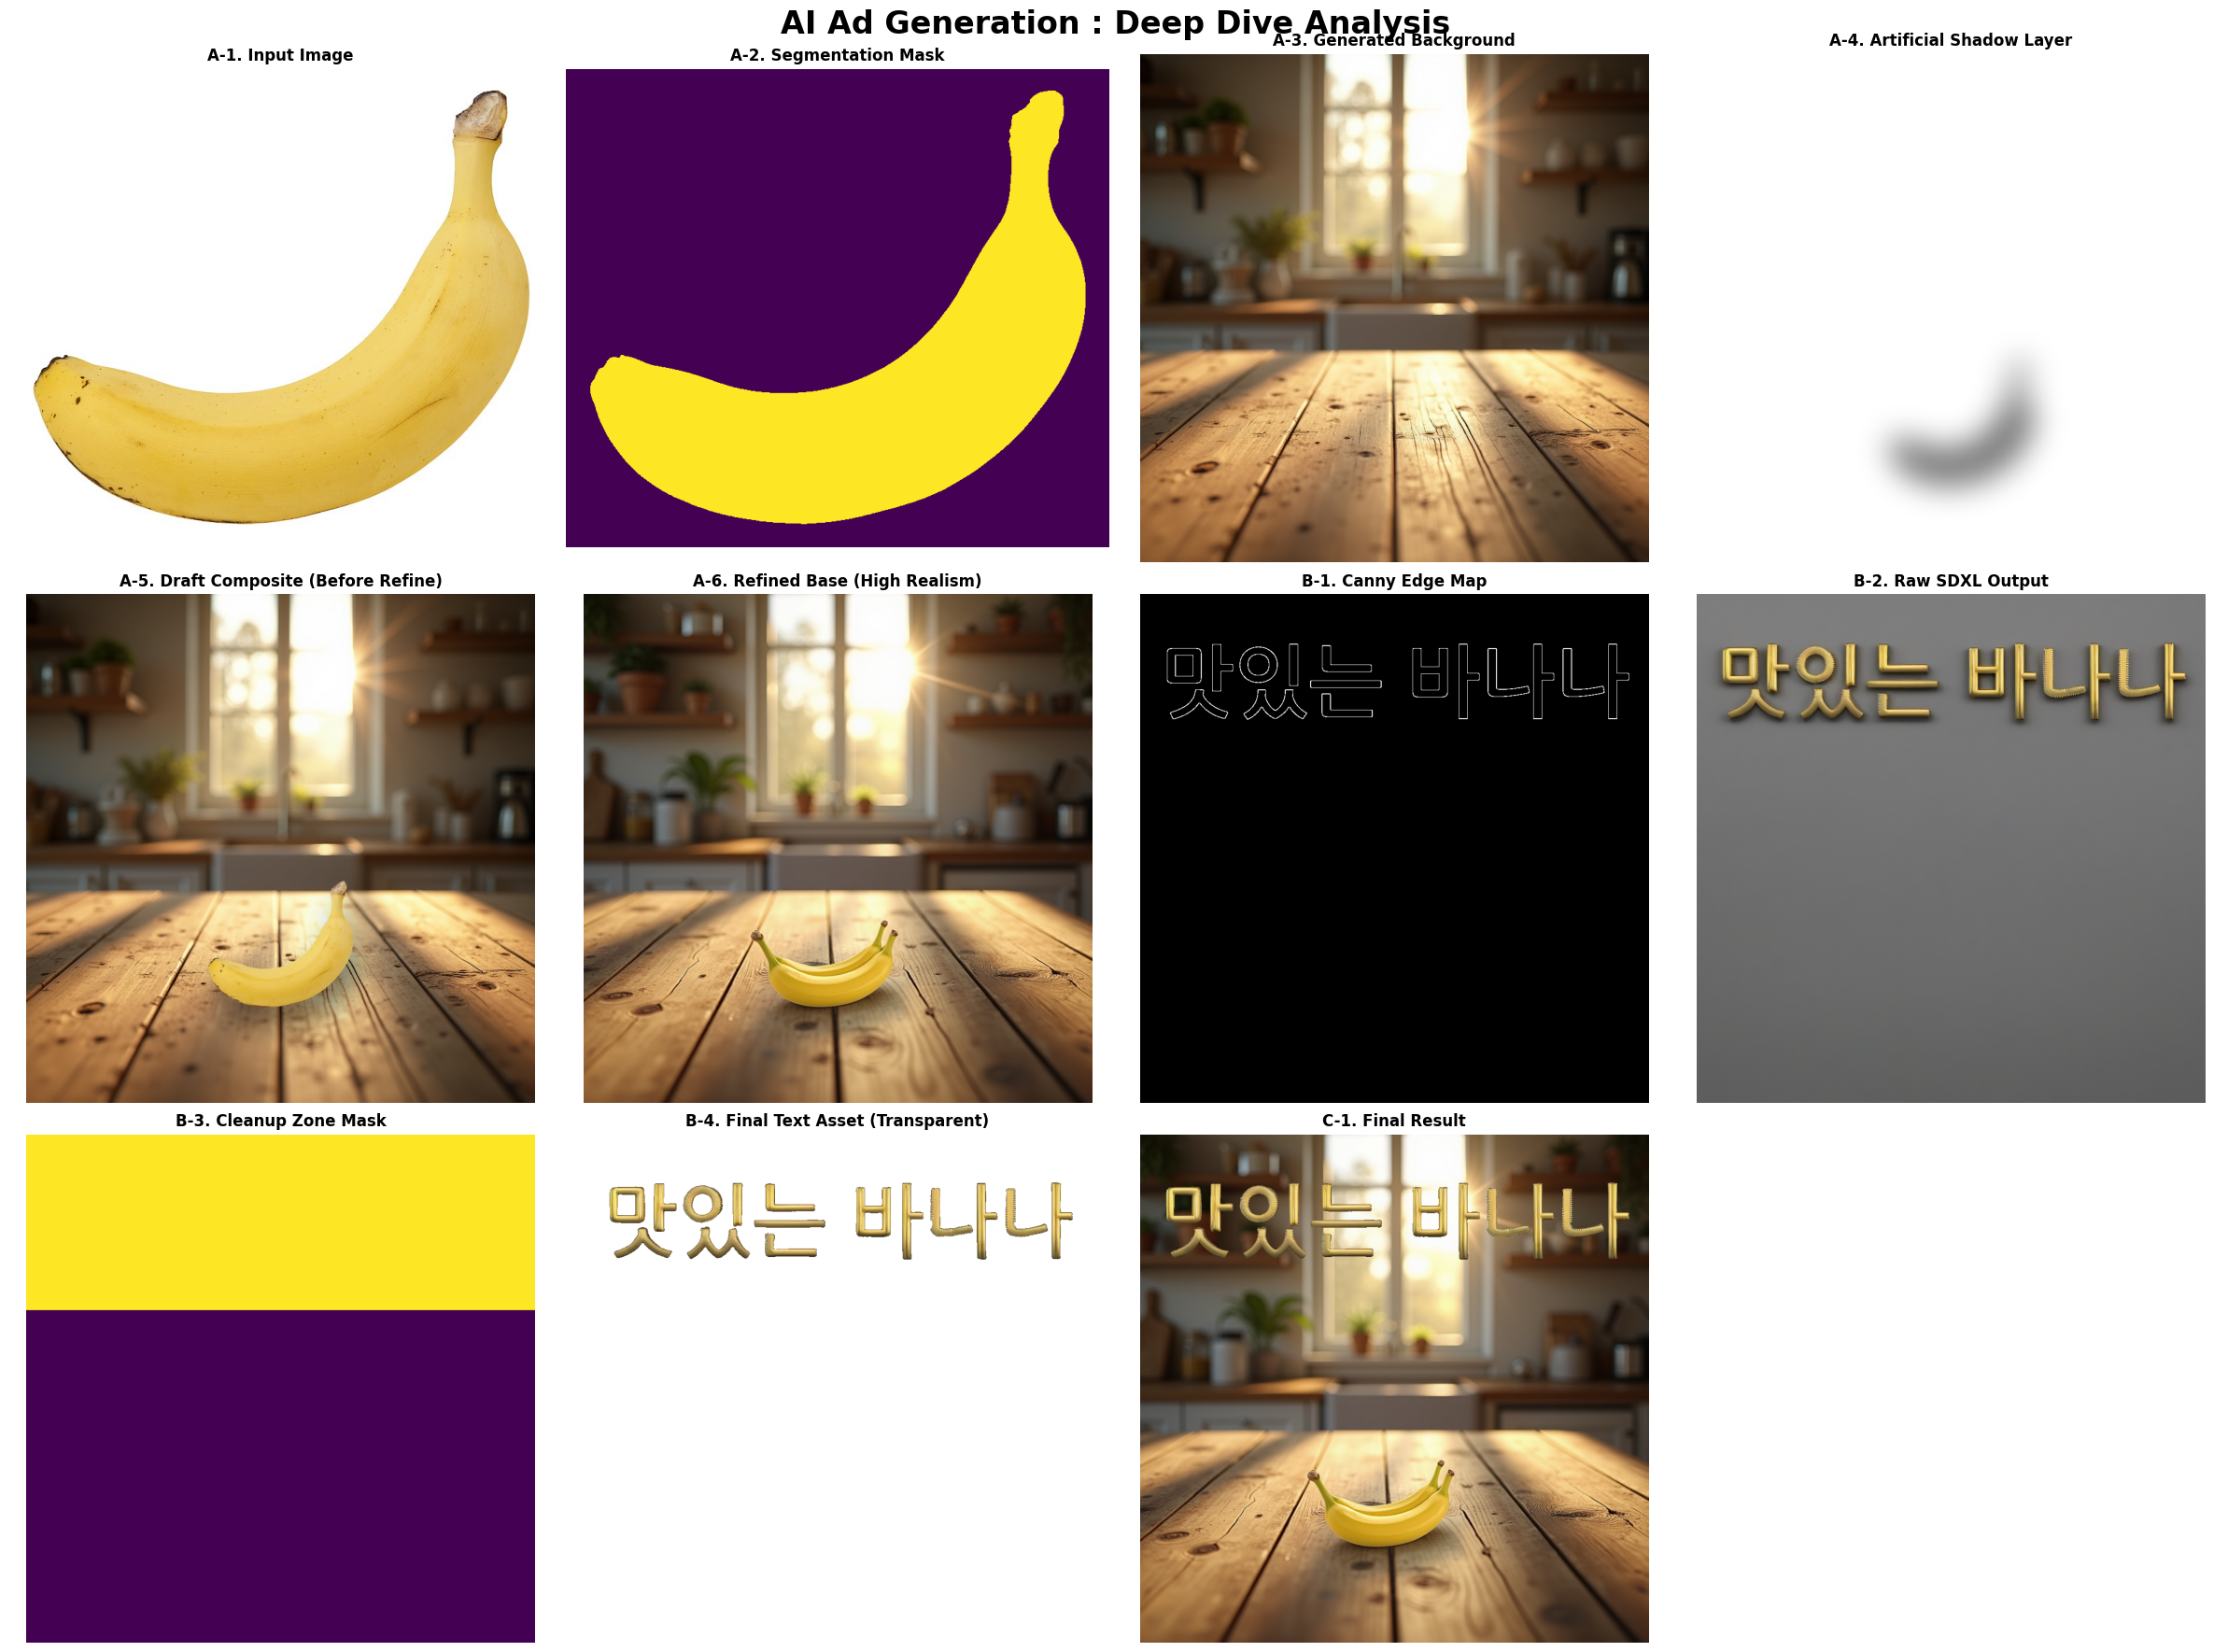


✨ 최종 결과 완료: final_result_v4.png


In [1]:
import torch
import gc
import os
import requests
import numpy as np
from PIL import Image, ImageDraw, ImageFont, ImageFilter, ImageOps, ImageChops
from torchvision import transforms
from transformers import AutoModelForImageSegmentation, BitsAndBytesConfig
from diffusers import (
    FluxPipeline,
    FluxImg2ImgPipeline, 
    FluxTransformer2DModel,
    StableDiffusionXLControlNetPipeline, 
    ControlNetModel, 
    AutoencoderKL
)
from diffusers.utils import load_image
import matplotlib.pyplot as plt

# ==========================================
# ⚙️ 설정
# ==========================================
DEVICE = "cuda"
TORCH_DTYPE = torch.bfloat16 

MODEL_IDS = {
    "SEG": "ZhengPeng7/BiRefNet",
    "FLUX": "black-forest-labs/FLUX.1-dev",
    "SDXL_BASE": "stabilityai/stable-diffusion-xl-base-1.0",
    "SDXL_CNET": "diffusers/controlnet-canny-sdxl-1.0",
    "SDXL_VAE": "madebyollin/sdxl-vae-fp16-fix"
}

def flush():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

def download_font(font_name="NanumGothicBold.ttf"):
    if not os.path.exists(font_name):
        url = "https://github.com/google/fonts/raw/main/ofl/nanumgothic/NanumGothic-Bold.ttf"
        r = requests.get(url)
        with open(font_name, 'wb') as f:
            f.write(r.content)
    return font_name

def pil_canny_edge(image):
    """
    [시각화 포인트] Canny Edge는 AI가 텍스트 형태를 인식하는 '설계도'입니다.
    검은 배경에 흰 선으로 표현됩니다.
    """
    gray = image.convert("L")
    edges = gray.filter(ImageFilter.FIND_EDGES)
    edges = edges.point(lambda x: 255 if x > 30 else 0)
    return edges.convert("RGB")

def visualize_detailed_report(images_dict):
    """
    12단계 상세 분석 리포트를 생성합니다.
    """
    n = len(images_dict)
    cols = 4  # 한 줄에 4개씩 배치
    rows = (n + cols - 1) // cols
    
    plt.figure(figsize=(24, 6 * rows))
    plt.suptitle("AI Ad Generation : Deep Dive Analysis", fontsize=24, fontweight='bold', y=0.98)
    
    for i, (key, img) in enumerate(images_dict.items()):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(key, fontsize=12, fontweight='bold')
        plt.axis('off')
        
        # 디버깅용 개별 파일 저장
        safe_name = f"debug_step_{i+1}.png"
        img.save(safe_name)

    plt.tight_layout()
    plt.show()

# --- AI Core Functions ---
def _run_birefnet_seg(image):
    print("    [AI] BiRefNet (누끼) 실행...")
    flush()
    birefnet = AutoModelForImageSegmentation.from_pretrained(
        MODEL_IDS["SEG"], trust_remote_code=True
    ).to(DEVICE).eval()
    
    W, H = image.size
    img_resized = image.resize((1024, 1024), Image.LANCZOS)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    input_tensor = transform(img_resized).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        preds = birefnet(input_tensor)[-1].sigmoid().cpu()
    pred = preds[0].squeeze()
    mask = transforms.ToPILImage()(pred).resize((W, H), Image.LANCZOS)
    mask = mask.point(lambda x: 255 if x > 128 else 0)
    
    result = image.copy()
    result.putalpha(mask)
    del birefnet, input_tensor
    flush()
    return result, mask

def _run_flux_bg_gen():
    print("    [AI] Flux (배경 생성) 실행...")
    flush()
    quant_config = BitsAndBytesConfig(load_in_8bit=True)
    transformer = FluxTransformer2DModel.from_pretrained(
        MODEL_IDS["FLUX"], subfolder="transformer", quantization_config=quant_config, torch_dtype=TORCH_DTYPE
    )
    pipe = FluxPipeline.from_pretrained(
        MODEL_IDS["FLUX"], transformer=transformer, torch_dtype=TORCH_DTYPE
    )
    pipe.enable_model_cpu_offload()
    
    prompt = (
        "A close-up view of a rustic wooden table surface. "
        "Soft morning sunlight coming from a window, creating gentle shadows. "
        "Blurred cozy kitchen background, bokeh, photorealistic, 8k, cinematic lighting."
    )
    image = pipe(
        prompt, height=1024, width=1024, num_inference_steps=25, guidance_scale=3.5,
        generator=torch.Generator("cpu").manual_seed(42)
    ).images[0]
    del pipe, transformer
    flush()
    return image

def _run_flux_refinement(draft_image):
    """
    [핵심] 사실적인 합성을 위한 고강도 리터칭
    """
    print("    [AI] Flux (리터칭) 실행 - 사실감 부여 중...")
    flush()
    quant_config = BitsAndBytesConfig(load_in_8bit=True)
    transformer = FluxTransformer2DModel.from_pretrained(
        MODEL_IDS["FLUX"], subfolder="transformer", quantization_config=quant_config, torch_dtype=TORCH_DTYPE
    )
    pipe = FluxImg2ImgPipeline.from_pretrained(
        MODEL_IDS["FLUX"], transformer=transformer, torch_dtype=TORCH_DTYPE
    )
    pipe.enable_model_cpu_offload()
    
    # 바나나와 테이블의 상호작용(그림자, 반사)을 강조하는 프롬프트
    prompt = (
        "A photorealistic close-up shot of a ripe yellow banana lying naturally on a rustic wooden table. "
        "Heavy contact shadows, ambient occlusion, wood texture reflection, "
        "warm sunlight, cinematic lighting, 8k, extremely detailed."
    )
    
    # Strength 0.65: 형태는 유지하되 접지면을 완전히 새로 그림
    refined_image = pipe(
        prompt, 
        image=draft_image,
        strength=0.65, 
        num_inference_steps=30, 
        guidance_scale=3.5,
        generator=torch.Generator("cpu").manual_seed(42)
    ).images[0]
    
    del pipe, transformer
    flush()
    return refined_image

def _run_sdxl_text_gen(canny_map, prompt):
    print("    [AI] SDXL (3D 텍스트) 실행...")
    flush()
    controlnet = ControlNetModel.from_pretrained(
        MODEL_IDS["SDXL_CNET"], torch_dtype=TORCH_DTYPE, use_safetensors=True
    )
    vae = AutoencoderKL.from_pretrained(MODEL_IDS["SDXL_VAE"], torch_dtype=TORCH_DTYPE)
    pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
        MODEL_IDS["SDXL_BASE"], controlnet=controlnet, vae=vae, torch_dtype=TORCH_DTYPE
    ).to(DEVICE)
    
    neg_prompt = "floor, ground, dirt, debris, random shapes, multiple objects, clutter, ugly, low quality"
    generated_img = pipe(
        prompt, negative_prompt=neg_prompt, image=canny_map, 
        controlnet_conditioning_scale=1.0, num_inference_steps=30
    ).images[0]
    del pipe, controlnet, vae
    flush()
    return generated_img

# ==========================================
# 🎨 STAGE A: 베이스 이미지 (Deep Viz)
# ==========================================
def run_stage_a_detail(image_path):
    print("\n🔶 [STAGE A] 베이스 이미지 생성...")
    report = {}
    
    # 1. 원본 분석
    raw_img = load_image(image_path).convert("RGB")
    report["A-1. Input Image"] = raw_img
    
    # 2. 누끼 마스크 시각화 (중요)
    product_fg, product_mask = _run_birefnet_seg(raw_img)
    # 마스크만 따로 보여주어 누끼 품질 확인
    report["A-2. Segmentation Mask"] = product_mask 
    
    # 3. 배경 생성
    bg_img = _run_flux_bg_gen()
    report["A-3. Generated Background"] = bg_img
    
    # 4. Draft 합성 (그림자 레이어 시각화)
    bg_w, bg_h = bg_img.size
    scale = 0.4
    fg_resized = product_fg.resize((int(product_fg.width*scale), int(product_fg.height*scale)), Image.LANCZOS)
    fg_mask = fg_resized.split()[-1]
    x = (bg_w - fg_resized.width) // 2
    y = int(bg_h * 0.55)
    
    shadow_layer = Image.new("RGBA", bg_img.size, (0,0,0,0))
    shadow_layer.paste((0,0,0,140), (x+20, y+40), mask=fg_mask)
    shadow_layer = shadow_layer.filter(ImageFilter.GaussianBlur(30))
    # 그림자 레이어만 따로 시각화 -> 인위적인 느낌 확인
    report["A-4. Artificial Shadow Layer"] = shadow_layer 
    
    base_comp = bg_img.convert("RGBA")
    base_comp = Image.alpha_composite(base_comp, shadow_layer)
    fg_layer = Image.new("RGBA", bg_img.size)
    fg_layer.paste(fg_resized, (x, y))
    base_comp = Image.alpha_composite(base_comp, fg_layer)
    
    draft_final = base_comp.convert("RGB")
    report["A-5. Draft Composite (Before Refine)"] = draft_final
    
    # 5. 리터칭 (Before & After 비교)
    refined_final = _run_flux_refinement(draft_final)
    report["A-6. Refined Base (High Realism)"] = refined_final
    
    return refined_final, report

# ==========================================
# 🅱️ STAGE B: 텍스트 자산 (Deep Viz)
# ==========================================
def run_stage_b_detail(text="맛있는 바나나"):
    print("\n🔶 [STAGE B] 텍스트 자산 생성...")
    report = {}
    W, H = 1024, 1024
    
    # 1. 가이드 생성 (Canny Map 시각화)
    font = ImageFont.truetype(download_font(), 160)
    text_guide = Image.new("RGB", (W, H), "black")
    draw = ImageDraw.Draw(text_guide)
    bbox = draw.textbbox((0,0), text, font=font)
    tw, th = bbox[2] - bbox[0], bbox[3] - bbox[1]
    text_x, text_y = (W - tw) // 2, 100
    draw.text((text_x, text_y), text, font=font, fill="white")
    
    canny_map = pil_canny_edge(text_guide)
    # AI가 텍스트를 어떻게 인식하는지 보여주는 뼈대 이미지
    report["B-1. Canny Edge Map"] = canny_map 
    
    # 2. SDXL Raw Output
    prompt = (
        "3D render of Gold foil balloon text, inflated, shiny metallic texture, "
        "floating in air, cinematic lighting, sharp details, isolated on black background"
    )
    raw_3d_text = _run_sdxl_text_gen(canny_map, prompt)
    report["B-2. Raw SDXL Output"] = raw_3d_text
    
    # 3. Cleanup Mask 시각화
    transparent_text, _ = _run_birefnet_seg(raw_3d_text)
    
    cleanup_mask = Image.new("L", (W, H), 0)
    mask_draw = ImageDraw.Draw(cleanup_mask)
    margin = 100 
    safe_area = (0, 0, W, text_y + th + margin)
    mask_draw.rectangle(safe_area, fill=255)
    # 삭제되는 영역(검정)과 보존되는 영역(흰색) 시각화
    report["B-3. Cleanup Zone Mask"] = cleanup_mask 
    
    # 4. Final Text
    r, g, b, a = transparent_text.split()
    clean_a = ImageChops.darker(a, cleanup_mask)
    final_text_asset = Image.merge("RGBA", (r, g, b, clean_a))
    report["B-4. Final Text Asset (Transparent)"] = final_text_asset
    
    return final_text_asset, report

# ==========================================
# 🖼️ STAGE C: 최종 합성
# ==========================================
def run_stage_c_detail(base_image, text_asset):
    print("\n🔶 [STAGE C] 최종 합성...")
    final_comp = base_image.convert("RGBA")
    final_comp = Image.alpha_composite(final_comp, text_asset)
    final_result = final_comp.convert("RGB")
    return {"C-1. Final Result": final_result}, final_result

# ==========================================
# 🚀 메인 실행
# ==========================================
def main_hyper_real_viz(image_path):
    print(f"🔥 [Start] Hyper-Realistic Pipeline with Deep Visualization")
    full_report = {}
    
    # A
    base_img, report_a = run_stage_a_detail(image_path)
    full_report.update(report_a)
    
    # B
    text_asset, report_b = run_stage_b_detail("맛있는 바나나")
    full_report.update(report_b)
    
    # C
    report_c, final_result = run_stage_c_detail(base_img, text_asset)
    full_report.update(report_c)
    
    # 시각화 리포트 출력
    visualize_detailed_report(full_report)
    final_result.save("final_result_v4.png")
    print("\n✨ 최종 결과 완료: final_result_v4.png")

main_hyper_real_viz("image.png")